In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv, GraphConv
from torch_geometric.data import Data, DataLoader
from sklearn.metrics import accuracy_score


In [2]:
!pip install torch_geometric

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.6/661.6 kB 19.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch_geometric: filename=torch_geometric-2.3.1-py3-none-any.whl size=910476 sha256=d3884ce4fac6c718bebf2c1a0e273084c8d76b86cfdce7197568264d14b26e50
  Stored in directory: /root/.cache/pip/wheels/ac/dc/30/e2874821ff308ee67dcd7a66dbde912411e19e35a1addda028
Successfully built torch_geometric


In [4]:
from sklearn.datasets import fetch_20newsgroups

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

X_train = newsgroups_train.data
y_train = newsgroups_train.target
X_test = newsgroups_test.data
y_test = newsgroups_test.target


In [5]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=2000)
X_train = vectorizer.fit_transform(X_train).toarray()
X_test = vectorizer.transform(X_test).toarray()


In [27]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_matrix = cosine_similarity(X_train)
edges = []
for i in range(similarity_matrix.shape[0]):
    for j in range(i+1, similarity_matrix.shape[0]):
        if similarity_matrix[i,j] > 0.5:
            edges.append((i,j))

data = Data(x=torch.tensor(X_train, dtype=torch.float),
            y=torch.tensor(y_train, dtype=torch.long),
            edge_index=torch.tensor(edges).t().contiguous())




In [28]:
similarity_matrix_test = cosine_similarity(X_test)
edges_test = []
for i in range(similarity_matrix_test.shape[0]):
    for j in range(i+1, similarity_matrix_test.shape[0]):
        if similarity_matrix_test[i,j] > 0.5:
            edges_test.append((i,j))

In [29]:
data_test = Data(x=torch.tensor(X_test, dtype=torch.float),
            y=torch.tensor(y_test, dtype=torch.long),
            edge_index=torch.tensor(edges_test).t().contiguous())


In [30]:
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGEModel, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [56]:

model = GraphSAGEModel(X_train.shape[1], 16, len(np.unique(y_train)))
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.CrossEntropyLoss()
train_loss = []
epoch_list = []
test_loss = []
split_idx = int(0.8 * data.num_nodes)
for epoch in range(200):
    model.train()
    for batch in DataLoader([data], batch_size=32, shuffle=True):
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index)
        loss = loss_fn(out, data.y)
        loss.backward()
        optimizer.step()
    model.eval()
    with torch.no_grad():
      out = model(data_test.x, data_test.edge_index)
      y_pred = out.argmax(dim=1)
      acc = (y_pred == data_test.y).sum().item() / len(data_test.y)
    print(f'Epoch {epoch}, Train Loss:',loss.item(),"Test Accuracy: ".format(acc))
    train_loss.append(loss.item())
    epoch_list.append(epoch)
    test_loss.append(acc)



Epoch 0, Train Loss: 3.647233009338379 Test Accuracy: 0.0469
Epoch 1, Train Loss: 3.5047974586486816 Test Accuracy: 0.0945
Epoch 2, Train Loss: 2.947329044342041 Test Accuracy: 0.0886
Epoch 3, Train Loss: 2.892564535140991 Test Accuracy: 0.0971
Epoch 4, Train Loss: 2.8550186157226562 Test Accuracy: 0.1058
Epoch 5, Train Loss: 2.8211510181427 Test Accuracy: 0.1172
Epoch 6, Train Loss: 2.788567543029785 Test Accuracy: 0.1263
Epoch 7, Train Loss: 2.7532763481140137 Test Accuracy: 0.1391
Epoch 8, Train Loss: 2.7167038917541504 Test Accuracy: 0.1560
Epoch 9, Train Loss: 2.681516170501709 Test Accuracy: 0.1749
Epoch 10, Train Loss: 2.644901752471924 Test Accuracy: 0.1892
Epoch 11, Train Loss: 2.6048693656921387 Test Accuracy: 0.2063
Epoch 12, Train Loss: 2.5611493587493896 Test Accuracy: 0.2266
Epoch 13, Train Loss: 2.516357183456421 Test Accuracy: 0.2452
Epoch 14, Train Loss: 2.470431089401245 Test Accuracy: 0.2566
Epoch 15, Train Loss: 2.420783519744873 Test Accuracy: 0.2642
Epoch 16, Trai

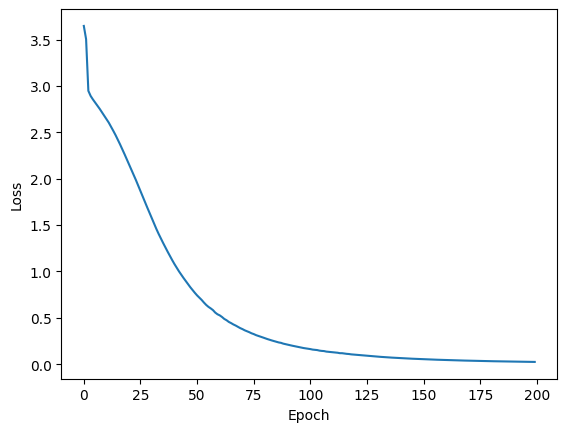

In [57]:
import matplotlib.pyplot as plt

plt.plot(epoch_list, train_loss, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


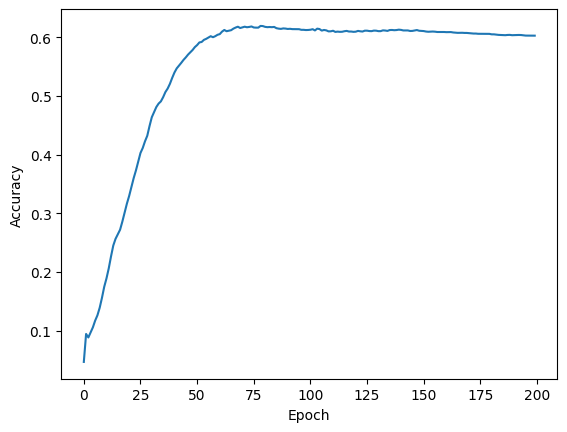

In [58]:
plt.plot(epoch_list, test_loss, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()